In [1]:
from collections import defaultdict

import pandas as pd
import glob
import json
import numpy as np
import ast
from tqdm import tqdm

from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# DBAASP parsing

In [2]:
def listofdicts_to_df(list_):
    activity_info = pd.DataFrame()
    if list_ != []:
        df_list = [pd.DataFrame.from_dict(dict_, orient='columns') for dict_ in list_]
        activity_info = pd.concat(df_list)
        if 'description' in activity_info.index:
            activity_info = activity_info.drop(['description'], axis=0)
    return activity_info

def flatten(list_):
    return [item for sublist in list_ for item in sublist]

def transfer_id(df, column):
    numbers = [len(x) for x in df[column]]
    id_list = flatten(list(map(lambda index, number: [index] * number, df.id.tolist(), numbers)))
    return id_list

def get_seq_len_less_than(df, seq_length):
    df_short = df[df['sequence'].apply(lambda x: len(str(x)) <= seq_length)]
    return df_short

def get_seq_len_more_than(df, seq_length):
    df_short = df[df['sequence'].apply(lambda x: len(str(x)) > seq_length)]
    return df_short

def get_peptides_with_bacterium_info(df, bacterium_list: list, exact=False):
    df_list = [] 
    for bacterium in bacterium_list:
        if exact:
            df_list.append(df[df['targetSpecies'] == bacterium])
            
        else:
            df_list.append(df[df['targetSpecies'].str.contains(bacterium)])
    df_short = pd.concat(df_list)
    return df_short

def get_broad_spectrum(df, bacterium_list: list):
    df_list = [] 
    for bacterium in bacterium_list:
        df_list.append(df[df['targetSpecies'].str.contains(bacterium)])
    common = set.intersection(*[set(df.id) for df in df_list])
    df_short = pd.concat([df[df.id.isin(common)] for df in df_list])
    return df_short    

def parse_str(s):
    try:
        return ast.literal_eval(str(s))
    except:
        return

def clean_concentration(df):
    replace_values = {'>' : '', ' ' : '', '<' : '', '=': ''} 
    clean_df = df.copy()
    clean_df = clean_df[~clean_df['concentration'].str.contains('-')]
    clean_df['clean_concentration'] = clean_df['concentration'].replace(replace_values, regex=True)
    clean_df['clean_concentration'] = [x.split('±')[0] for x in clean_df['clean_concentration']]
    clean_df['clean_concentration'] = [parse_str(x) for x in clean_df['clean_concentration']]
    clean_df['clean_concentration'] = [x if type(x) is not tuple else np.nan for x in clean_df['clean_concentration'] ]    
    clean_df = clean_df.dropna(subset=['clean_concentration'])    
    return clean_df

def clean_up_conditions(df):
    clean_df = df[df['ph'] == '']
    clean_df = clean_df[clean_df['saltType'] == '']
    clean_df = clean_df[clean_df['concentration'] != '']
    return clean_df

def filter_by_acitivity(df, activity_column, threshold, mode=['active', 'inactive']):
    if mode == 'active':
        df_short = df[df[activity_column] <= threshold]
    elif mode == 'inactive':
        df_short = df[df[activity_column] > threshold]
    return df_short


def filter_by_acitivity_(df, activity_column, threshold):
    df_active = df[df[activity_column] <= threshold]
    df_inactive = df[df[activity_column] > threshold]
    return df_active, df_inactive


def prepare_for_fasta(df):
    fasta_df = pd.DataFrame()
    fasta_df['header'] = '>' + 'DBAASP' + '_' + df['id'].map(str)
    fasta_df['sequence'] = df['sequence'] 
    fasta_df = fasta_df.drop_duplicates(subset=['header'])
    return fasta_df

def remove_inconsistent_entries(active_df, inactive_df):
    weird_peptides = set(active_df.sequence.tolist()) & set(inactive_df.sequence.tolist())
    active_df_clean = active_df[~active_df.sequence.isin(weird_peptides)]
    inactive_df_clean = inactive_df[~inactive_df.sequence.isin(weird_peptides)] 
    return active_df_clean, inactive_df_clean

In [3]:
DBAASP_FOLDER = '../../temp_data/json'

In [4]:
peptides = pd.DataFrame()
all_file_names = []
total = 0
unusual_amino_acids = 0
for j_file in glob.glob(f"{DBAASP_FOLDER}/*.json"):
    total += 1
    filename = j_file[j_file.rfind("/") + 1:]
    with open(j_file) as train_file:
        dict_train = json.load(train_file)
    if dict_train.get("unusualAminoAcids") != []:
        unusual_amino_acids += 1
        continue
    peptide = pd.DataFrame.from_dict(dict_train, orient='index')
    peptides = pd.concat([peptides, peptide], axis=1)
    all_file_names.append(filename)
peptides = peptides.T    
print ("Total number of entries:", total)
print ("Total number of entries with unusual AminoAcids:", unusual_amino_acids)
print ("Total number of valid sequences:", peptides.sequence.nunique())
print ("Total number of valid entries:", len(peptides))

Total number of entries: 18621
Total number of entries with unusual AminoAcids: 4198
Total number of valid sequences: 12725
Total number of valid entries: 14423


In [5]:
# Drop entries without sequence
peptides['sequence'] = peptides['sequence'].str.strip()
peptides = peptides.dropna(subset=['sequence'])
peptides = peptides.reset_index().drop('index', axis=1)
len(peptides)

14249

In [6]:
# Get sequences longer than 10 and shorter than 25
before_len_filtering = peptides.sequence.nunique()
peptides = get_seq_len_less_than(peptides, 35)
peptides = get_seq_len_more_than(peptides, 10)
after_len_filtering = peptides.sequence.nunique()

print ("Peptides removed:", before_len_filtering - after_len_filtering)
print ("Total number of peptides within range:", after_len_filtering)

Peptides removed: 3276
Total number of peptides within range: 9447


In [7]:
# Drop entries with d-aminoacids
peptides = peptides[peptides.sequence.str.isupper()]
peptides = peptides.reset_index().drop('index', axis=1)
peptides.sequence.nunique()

9439

In [8]:
peptides = peptides.loc[:, [
    'id',
    'name',
    'sequence',
    'nTerminus',
    'cTerminus',
    'targetActivities',
    'hemoliticCytotoxicActivities',
]]

In [9]:
sequence_info = peptides.drop(['targetActivities', 'hemoliticCytotoxicActivities'], axis=1)
sequence_info['cTerminus'] = [x['name'] if x is not None else np.nan for x in sequence_info['cTerminus']]
sequence_info['nTerminus'] = [x['name'] if x is not None else np.nan for x in sequence_info['nTerminus']]
sequence_info.sequence.nunique()

9439

# Activity analysis

In [10]:
activity_info = pd.concat([listofdicts_to_df(x) for x in tqdm(peptides['targetActivities'])])
activity_info['id'] = transfer_id(peptides, 'targetActivities')
activity_info = activity_info.reset_index().drop('index', axis=1)    

100%|██████████| 10119/10119 [02:04<00:00, 81.41it/s]


This set of conditions is picked so that the activity can be compared between peptides. 

In [11]:
activity_info = activity_info[activity_info['activityMeasureValue'] == 'MIC']
activity_info_cfuGroup = activity_info[activity_info['cfuGroup'] == '1E5 - 1E6'] 
activity_info_cfu1E5 = activity_info[activity_info['cfu'] == '1E5']
activity_info_cfu1E6 = activity_info[activity_info['cfu'] == '1E6']

activity_info = pd.concat([
    activity_info_cfuGroup,
    activity_info_cfu1E5,
    activity_info_cfu1E6]
)
activity_info = activity_info.drop_duplicates()

allowed_media = ['MHB', 'MHA', 'LBB', 'LBA', 'TSB', 'TSA', 'CAMHB'] 
activity_info = activity_info[activity_info['medium'].isin(allowed_media)]



activity_info = clean_up_conditions(activity_info)
activity_info = clean_concentration(activity_info)

In [12]:
activity_info = activity_info.drop([
    'reference',
    'activity',
    'activityMeasureValue',
    'activityMeasureGroup', 
    'cfuGroup',
    'ph',
    'saltType',
    'ionicStrength',
    
], axis=1)

activity_info = activity_info.rename(columns={
    'concentration': 'mic',
    'clean_concentration': 'mic_clean',    
    'unit': 'mic_unit',
    'medium': 'mic_medium',
    'cfu': 'mic_cfu',
    'note': 'mic_note'
})

# Toxicity info

In [13]:
toxicity_info = pd.concat([listofdicts_to_df(x) for x in tqdm(peptides['hemoliticCytotoxicActivities'])])
toxicity_info['id'] = transfer_id(peptides, 'hemoliticCytotoxicActivities')
toxicity_info = toxicity_info.reset_index().drop('index', axis=1)    

100%|██████████| 10119/10119 [00:16<00:00, 595.49it/s]


In [14]:
toxicity_info = toxicity_info[toxicity_info['activityMeasureForLysisValue'].str.contains('Hemolysis')]
toxicity_info = toxicity_info[~toxicity_info['activityMeasureForLysisValue'].str.contains('±')]
toxicity_info = toxicity_info[~toxicity_info['activityMeasureForLysisValue'].str.contains('>')]
toxicity_info = toxicity_info[~toxicity_info['activityMeasureForLysisValue'].str.contains('-')]
toxicity_info = toxicity_info[~toxicity_info['activityMeasureForLysisValue'].str.contains('<')]
toxicity_info = toxicity_info[~toxicity_info['activityMeasureForLysisValue'].str.contains('≤')]

toxicity_info['activityMeasureForLysisValue'].unique() 

array(['0% Hemolysis', '50% Hemolysis', '10% Hemolysis', '90% Hemolysis',
       '25% Hemolysis', '5% Hemolysis', '0.5% Hemolysis', '6% Hemolysis',
       '8% Hemolysis', '14% Hemolysis', '19% Hemolysis',
       '88.6% Hemolysis', '66% Hemolysis', '39.5% Hemolysis',
       '17.8% Hemolysis', '13.1% Hemolysis', '3% Hemolysis',
       '44% Hemolysis', '59% Hemolysis', '15% Hemolysis', '47% Hemolysis',
       '68% Hemolysis', '73% Hemolysis', '21% Hemolysis', '85% Hemolysis',
       '75% Hemolysis', '84% Hemolysis', '18.8% Hemolysis',
       '1% Hemolysis', '12% Hemolysis', '55% Hemolysis', '4.6% Hemolysis',
       '43.4% Hemolysis', '2% Hemolysis', '13% Hemolysis',
       '29% Hemolysis', '30% Hemolysis', '43% Hemolysis', '83% Hemolysis',
       '98% Hemolysis', '9.49% Hemolysis', '28% Hemolysis',
       '8.6% Hemolysis', '5.7% Hemolysis', '49.7% Hemolysis',
       '87.2% Hemolysis', '92.5% Hemolysis', '100% Hemolysis',
       '3.4% Hemolysis', '7% Hemolysis', '53.9% Hemolysis',
       '

In [15]:
toxicity_info = clean_up_conditions(toxicity_info)
toxicity_info = clean_concentration(toxicity_info)

def get_toxicity(measure, value):
    if measure == '50% Hemolysis':
        hc50_value = value
    else:
        if measure == '0% Hemolysis': 
            prct_hemolysis = 0.1
        else:
            prct_hemolysis = float(measure.split('%')[0])
        hc50_value = 50 * value / prct_hemolysis
    return hc50_value

def get_valid_hc50(measure, value):
    if measure == '50% Hemolysis':
        return value    
    
    
toxicity_info['extrapolated_hc50'] = toxicity_info.apply(
    lambda x: 
    get_toxicity(x['activityMeasureForLysisValue'],
                 x['clean_concentration']), axis=1
)



toxicity_info['hc50_clean'] = toxicity_info.apply(
    lambda x: 
    get_valid_hc50(x['activityMeasureForLysisValue'],
                 x['clean_concentration']), axis=1
)

In [16]:
# toxicity_info = toxicity_info[toxicity_info['activityMeasureForLysisValue'] == '50% Hemolysis']

toxicity_info = toxicity_info.drop([
    'reference',
    'activity',
    'activityMeasureForLysisGroup', 
    'ph',
    'saltType',
    'ionicStrength'
], axis=1)

toxicity_info = toxicity_info.rename(columns={
    'concentration': 'hc_value',
    'clean_concentration': 'hc_value_clean',
    'activityMeasureForLysisValue': 'hc_measure',
    'extrapolated_hc50': 'hc50_extrapolated',    
    'unit': 'hc_unit',
    'note': 'hc_note'
})

# Remove sequence with conflicting entries e.g. 
toxicity_info_no_duplicates = toxicity_info.drop_duplicates(subset='id', keep=False)
tox_std = toxicity_info[toxicity_info.duplicated(subset=['id'], keep=False)].groupby('id').hc50_clean.std()
tox_std_index = (tox_std < 1).index
toxicity_info_duplicates = toxicity_info[toxicity_info.id.isin(tox_std_index)]

clean_toxicity_info = pd.concat([toxicity_info_no_duplicates, toxicity_info_duplicates])
assert(len(toxicity_info_duplicates) + len(toxicity_info_no_duplicates) == len(clean_toxicity_info))

In [17]:
activity_info = sequence_info.merge(activity_info, how='inner')
activity_info = activity_info.merge(clean_toxicity_info, how='left')

In [18]:
activity_info.targetSpecies.value_counts()

Escherichia coli ATCC 25922                2210
Staphylococcus aureus ATCC 25923           1584
Pseudomonas aeruginosa ATCC 27853          1347
Staphylococcus aureus ATCC 29213            753
Escherichia coli                            575
                                           ... 
Serratia marcescens ATCC 14041                1
Klebsiella pneumoniae KAY 2026                1
Salmonella Potsdam CICC 21500                 1
Bacteroides thetaiotaomicron ATCC 29741       1
Escherichia coli ATCC BAA-2469                1
Name: targetSpecies, Length: 1647, dtype: int64

In [20]:
STRAINS = {
    'Escherichia coli': ['ATCC 25922'], 
    'Staphylococcus aureus': ['ATCC 25923', 'ATCC 29213'], 
    'Klebsiella pneumoniae': ['ATCC 700603', 'ATCC 13883'], 
    'Acinetobacter baumannii': ['ATCC 19606'],
    'Pseudomonas aeruginosa': ['ATCC 29213', 'ATCC 9027'],
    'Enterococcus faecalis': ['ATCC 29212'],
    'Enterococcus faecium': ['ATCC 700221'], 
    'Klebsiella aerogenes': ['ATCC 13048'],
}



In [21]:
activity_info

,id,name,sequence,nTerminus,cTerminus,targetSpecies,mic,mic_unit,mic_medium,mic_cfu,mic_note,mic_clean,targetCell,hc_measure,hc_value,hc_unit,hc_note,hc_value_clean,hc50_extrapolated,hc50_clean
0,1451,V681 [S11A],KWKSFLKTFKAAVKTVLHTALKAISS,ACT,AMD,Escherichia coli UB1005,6.4,µg/ml,LBB,5E5,Wild type strain,6.4,Human erythrocytes,0% Hemolysis,15.6,µg/ml,,15.6,7800.0,NaN
1,1451,V681 [S11A],KWKSFLKTFKAAVKTVLHTALKAISS,ACT,AMD,Escherichia coli DC2,4.0,µg/ml,LBB,5E5,Antibiotics-sensitive strain,4.0,Human erythrocytes,0% Hemolysis,15.6,µg/ml,,15.6,7800.0,NaN
2,1451,V681 [S11A],KWKSFLKTFKAAVKTVLHTALKAISS,ACT,AMD,Salmonella typhimurium C587,20.2,µg/ml,LBB,5E5,Wild type strain,20.2,Human erythrocytes,0% Hemolysis,15.6,µg/ml,,15.6,7800.0,NaN
3,1451,V681 [S11A],KWKSFLKTFKAAVKTVLHTALKAISS,ACT,AMD,Salmonella typhimurium C610,4.0,µg/ml,LBB,5E5,Antibiotics-sensitive strain,4.0,Human erythrocytes,0% Hemolysis,15.6,µg/ml,,15.6,7800.0,NaN
4,1451,V681 [S11A],KWKSFLKTFKAAVKTVLHTALKAISS,ACT,AMD,Pseudomonas aeruginosa H187,10.1,µg/ml,LBB,5E5,Wild type strain,10.1,Human erythrocytes,0% Hemolysis,15.6,µg/ml,,15.6,7800.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31963,3387,Temporin-Ra,FLKPLFNAALKLLP,NaN,AMD,Escherichia coli HP101BA 7601c,24.2±1.2,µg/ml,MHB,1E5,,24.2,Human erythrocytes,1% Hemolysis,60,µg/ml,,60.0,3000.0,NaN
31964,3387,Temporin-Ra,FLKPLFNAALKLLP,NaN,AMD,Streptococcus dysgalactiae PTCC 1074,33.2±2.4,µg/ml,MHB,1E5,,33.2,Human erythrocytes,1% Hemolysis,60,µg/ml,,60.0,3000.0,NaN
31965,3387,Temporin-Ra,FLKPLFNAALKLLP,NaN,AMD,Streptococcus agalactiae PTCC 1365,24.7±1.2,µg/ml,MHB,1E5,,24.7,Human erythrocytes,1% Hemolysis,60,µg/ml,,60.0,3000.0,NaN
31966,3387,Temporin-Ra,FLKPLFNAALKLLP,NaN,AMD,Staphylococcus aureus PTCC 1431,35.2±1,µg/ml,MHB,1E5,,35.2,Human erythrocytes,1% Hemolysis,60,µg/ml,,60.0,3000.0,NaN


In [22]:
all_seqs = []

for species, strains in STRAINS.items():
    with_info = get_peptides_with_bacterium_info(
        activity_info,
        [species + ' ' + strain for strain in strains],
        exact=True,
    )
    assert(with_info.targetSpecies.nunique() <= len(strains)), with_info.targetSpecies.unique()
    all_seqs += with_info.sequence.tolist()
    active, inactive = filter_by_acitivity_(with_info, 'mic_clean', 32)
    
    assert(len(active) + len(inactive)) == len(with_info)

    
    active, inactive  = remove_inconsistent_entries(active, inactive)
    print(f'{species} active: ', active.sequence.nunique())
    print(f'{species} inactive: ', inactive.sequence.nunique())
    
    raw_species = ''.join(species.split()).lower()
    prepare_for_fasta(active).to_csv(f'../../data/dbaasp/{raw_species}_active.tsv', sep='\t', index=False, header=False)
    prepare_for_fasta(inactive).to_csv(f'../../data/dbaasp/{raw_species}_inactive.tsv', sep='\t', index=False, header=False)
    
    ! awk '{{print ""$$1"\n"$$2}}' ../../data/dbaasp/{raw_species}_active.tsv > ../../data/dbaasp/{raw_species}_active.fasta
    ! awk '{{print ""$$1"\n"$$2}}' ../../data/dbaasp/{raw_species}_inactive.tsv > ../../data/dbaasp/{raw_species}_inactive.fasta
    

toxic, nontoxic = filter_by_acitivity_(activity_info, 'hc50_extrapolated', 32)
toxic, nontoxic  = remove_inconsistent_entries(toxic, nontoxic)

prepare_for_fasta(toxic).to_csv(f'../../data/dbaasp/toxic.tsv', sep='\t', index=False, header=False)
prepare_for_fasta(nontoxic).to_csv(f'../../data/dbaasp/nontoxic.tsv', sep='\t', index=False, header=False)

! awk '{{print ""$$1"\n"$$2}}' ../../data/dbaasp/toxic.tsv > ../../data/dbaasp/toxic.fasta
! awk '{{print ""$$1"\n"$$2}}' ../../data/dbaasp/nontoxic.tsv > ../../data/dbaasp/nontoxic.fasta
    

print(f'Number of unique sequences: {len(set(all_seqs))}')

Escherichia coli active:  1109
Escherichia coli inactive:  405
Staphylococcus aureus active:  851
Staphylococcus aureus inactive:  530
Klebsiella pneumoniae active:  307
Klebsiella pneumoniae inactive:  121
Acinetobacter baumannii active:  195
Acinetobacter baumannii inactive:  34
Pseudomonas aeruginosa active:  90
Pseudomonas aeruginosa inactive:  65
Enterococcus faecalis active:  165
Enterococcus faecalis inactive:  138
Enterococcus faecium active:  13
Enterococcus faecium inactive:  6
Klebsiella aerogenes active:  0
Klebsiella aerogenes inactive:  0
Number of unique sequences: 2027


In [23]:
activity_info.targetSpecies.value_counts()

Escherichia coli ATCC 25922                2210
Staphylococcus aureus ATCC 25923           1584
Pseudomonas aeruginosa ATCC 27853          1347
Staphylococcus aureus ATCC 29213            753
Escherichia coli                            575
                                           ... 
Serratia marcescens ATCC 14041                1
Klebsiella pneumoniae KAY 2026                1
Salmonella Potsdam CICC 21500                 1
Bacteroides thetaiotaomicron ATCC 29741       1
Escherichia coli ATCC BAA-2469                1
Name: targetSpecies, Length: 1647, dtype: int64

In [24]:
ecoli = get_peptides_with_bacterium_info(activity_info, ['Escherichia coli ATCC 25922'])
saureus = get_peptides_with_bacterium_info(activity_info, ['ATCC 25923'])
kpneumoniae = get_peptides_with_bacterium_info(activity_info, ['ATCC 700603'])

ecoli_active, ecoli_inactive = filter_by_acitivity_(ecoli, 'mic_clean', 32)
ecoli_active, ecoli_inactive  = remove_inconsistent_entries(ecoli_active, ecoli_inactive)
ecoli = pd.concat([ecoli_active, ecoli_inactive])

saureus_active, saureus_inactive = filter_by_acitivity_(saureus, 'mic_clean', 32)
saureus_active, saureus_inactive  = remove_inconsistent_entries(saureus_active, saureus_inactive)
saureus = pd.concat([saureus_active, saureus_inactive])


kpneumoniae_active, kpneumoniae_inactive = filter_by_acitivity_(kpneumoniae, 'mic_clean', 32)
kpneumoniae_active, kpneumoniae_inactive  = remove_inconsistent_entries(kpneumoniae_active, kpneumoniae_inactive)
kpneumoniae = pd.concat([kpneumoniae_active, kpneumoniae_inactive])

paeruginosa = get_peptides_with_bacterium_info(activity_info, ['ATCC 27853'])
paeruginosa_active, paeruginosa_inactive = filter_by_acitivity_(paeruginosa, 'mic_clean', 32)
paeruginosa_active, paeruginosa_inactive  = remove_inconsistent_entries(paeruginosa_active, paeruginosa_inactive)
paeruginosa = pd.concat([paeruginosa_active, paeruginosa_inactive])

toxic, nontoxic = filter_by_acitivity_(activity_info, 'hc50_extrapolated', 32)
toxic, nontoxic  = remove_inconsistent_entries(toxic, nontoxic)
toxicity = pd.concat([toxic, nontoxic])





In [36]:
get_seq_len_more_than(get_seq_len_less_than(nontoxic, 25), 15).drop_duplicates(subset=["sequence"]).sort_values(by='hc_value_clean', ascending=False)[0:30]

,id,name,sequence,nTerminus,cTerminus,targetSpecies,mic,mic_unit,mic_medium,mic_cfu,mic_note,mic_clean,targetCell,hc_measure,hc_value,hc_unit,hc_note,hc_value_clean,hc50_extrapolated,hc50_clean
24372,10291,"Medusin-PT, Phylloseptin-4TR",LLGMIPVAITAISALSKL,NaN,AMD,Staphylococcus aureus NCTC 10788,64,µg/ml,MHB,1E5,,64.000,Horse erythrocytes,50% Hemolysis,1.814E6,µg/ml,,1814000.0,1.814000e+06,1814000.0
18084,350,,CVKVQVKVGSGVKVQVKVC,ACT,AMD,Escherichia coli ATCC 25922,0.010,µM,MHB,2E5-7E5,,0.010,Human erythrocytes,50% Hemolysis,3226,µM,,3226.0,3.226000e+03,3226.0
9463,17062,LK [L8D],LKKLLKLDKKLLKLAG,NaN,NaN,Escherichia coli ATCC 25922,10,µM,MHB,5E5,,10.000,Human erythrocytes,10% Hemolysis,1280,µM,,1280.0,6.400000e+03,NaN
24979,18494,Lynronne-1 [V15T],LPRRNRWSKIWKKVTTVFS,NaN,NaN,Acinetobacter baumannii ATCC 19606,16,µg/ml,CAMHB,7.5E5,,16.000,Horse erythrocytes,0% Hemolysis,>1200,µg/ml,,1200.0,6.000000e+05,NaN
14767,351,,CAKAKAKAGSGAKAKAKAC,ACT,AMD,Escherichia coli ATCC 25922,0.173,µM,MHB,2E5-7E5,,0.173,Human erythrocytes,50% Hemolysis,1055,µM,,1055.0,1.055000e+03,1055.0
19096,1417,"HB71, Shiva 10 (1-18)",FAKKLAKKLKKLAKKLAK,NaN,NaN,Escherichia coli UB1005,2,µg/ml,MHA,1E5-1E6,,2.000,Human erythrocytes,50% Hemolysis,>1000,µg/ml,,1000.0,1.000000e+03,1000.0
10237,12530,"Odorranain-B1 (1-17)[L3K, K9V], Dadapin-8",AAKKGCWTVSIPPKPCF,NaN,AMD,Staphylococcus aureus ATCC 29213,16,µM,MHB,5E5,,16.000,Human erythrocytes,50% Hemolysis,>1000,µM,,1000.0,1.000000e+03,1000.0
11687,18495,"Lynronne-1 [I10T,V15T]",LPRRNRWSKTWKKVTTVFS,NaN,NaN,Staphylococcus aureus ATCC 29213,>256,µg/ml,CAMHB,7.5E5,,256.000,Horse erythrocytes,0% Hemolysis,970,µg/ml,,970.0,4.850000e+05,NaN
25002,5476,H/V-peptide (1-11)(19-25),GILKTIKSIASKLKRKAK,NaN,NaN,Escherichia coli ATCC 25922,1.56,µM,MHB,5E5,,1.560,Human erythrocytes,50% Hemolysis,923,µM,,923.0,9.230000e+02,923.0
7371,347,,CVKVKVKVGSGVKVKVKVC,ACT,AMD,Escherichia coli ATCC 25922,<=0.005,µM,MHB,2E5-7E5,,0.005,Human erythrocytes,50% Hemolysis,880,µM,,880.0,8.800000e+02,880.0


In [25]:
print('E. coli active: ', ecoli_active.sequence.nunique())
print('E. coli inactive: ',  ecoli_inactive.sequence.nunique())

print('S. aureus active: ',  saureus_active.sequence.nunique())
print('S. aureus inactive: ',  saureus_inactive.sequence.nunique())


print('K. pneumoniae active: ',  kpneumoniae_active.sequence.nunique())
print('K. pneumoniae inactive: ',  kpneumoniae_inactive.sequence.nunique())


print('P. aeruginosa active: ',  paeruginosa_active.sequence.nunique())
print('P. aeruginosa inactive: ',  paeruginosa_inactive.sequence.nunique())


print('Toxic: ',  toxic.sequence.nunique())
print('Non-toxic: ',  nontoxic.sequence.nunique())

E. coli active:  1108
E. coli inactive:  405
S. aureus active:  673
S. aureus inactive:  360
K. pneumoniae active:  193
K. pneumoniae inactive:  82
P. aeruginosa active:  601
P. aeruginosa inactive:  372
Toxic:  228
Non-toxic:  1734


In [27]:
prepare_for_fasta(ecoli).to_csv(f'../../data/dbaasp/ecoli.tsv', sep='\t', index=False, header=False)
! awk '{{print ""$$1"\n"$$2}}' ../../data/dbaasp/ecoli.tsv > ../../data/dbaasp/ecoli.fasta

# Do CD-HIT clustering 
On whole dbaasp database using fasta minput
Sequence identity cut-off = 0.8 

In [28]:
clusters = defaultdict(str)
with open('../../data/dbaasp/1649857712.fas.1.clstr.sorted') as f:
    lines = f.readlines()
    for line in lines:
        if line[0] == '>': 
            cluster = line.translate({ord(x): '' for x in ['\n', '>']})
            cluster = cluster.split('Cluster')[1].strip()
            cluster = int(cluster)
        else:
            entry = line.replace('...', '>').split('>')[1]
            entry = entry.split('_')[1]
            entry = np.nan if entry.strip() == '' else int(entry)
#             entry = np.nan if entry.strip() == '' else entry
            clusters[entry] = cluster
            
ecoli['cluster'] = ecoli['id'].map(clusters)             

In [31]:
ecoli.sort_values(by='cluster')

,id,name,sequence,nTerminus,cTerminus,targetSpecies,mic,mic_unit,mic_medium,mic_cfu,...,mic_clean,targetCell,hc_measure,hc_value,hc_unit,hc_note,hc_value_clean,hc50_extrapolated,hc50_clean,cluster
25,11737,Tachyplesin-1 [Y8A],KWCFRVCARGICYRRCR,NaN,NaN,Escherichia coli ATCC 25922,0.06,µg/ml,MHB,5E5,...,0.060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
21725,11761,"Tachyplesin-1 [R9A,R17A]",KWCFRVCYAGICYRRCA,NaN,NaN,Escherichia coli ATCC 25922,0.03,µg/ml,MHB,5E5,...,0.030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
26492,11734,Tachyplesin-1 [R5A],KWCFAVCYRGICYRRCR,NaN,NaN,Escherichia coli ATCC 25922,0.125,µg/ml,MHB,5E5,...,0.125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
26682,11745,"Tachyplesin-1 [C3S,C16A]",KWSFRVCYRGICYRRAR,NaN,NaN,Escherichia coli ATCC 25922,0.25,µg/ml,MHB,5E5,...,0.250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
13465,11752,Tachyplesin-1 [F4G],KWCGRVCYRGICYRRCR,NaN,NaN,Escherichia coli ATCC 25922,0.25,µg/ml,MHB,5E5,...,0.250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18778,17636,,RKIKKRRKKWR,NaN,AMD,Escherichia coli ATCC 25922,>50,µg/ml,MHB,1E5-5E5,...,50.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,578
20051,17639,,RQPKIPRMPWR,NaN,AMD,Escherichia coli ATCC 25922,>50,µg/ml,MHB,1E5-5E5,...,50.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,579
20305,16323,"Ranacyclin-AJ (3-20)[G5,18;C6,16;T8;S10,12Del]...",FRWKYPKPLKR,NaN,NaN,Escherichia coli ATCC 25922,>100,µg/ml,LBB,2E5,...,100.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,580
23781,14765,"Mucin-7 (20-31) [H3A, P10del]",KSAFELPHYGL,NaN,NaN,Escherichia coli ATCC 25922,>500,µM,LBB,1E6,...,500.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,581


In [32]:
ecoli.to_csv('../../data/dbaasp/ecoli_clean.tsv', sep='\t')

# Get broad activity

In [33]:
broad = get_broad_spectrum(activity_info, [
    'ATCC 25922', #E. coli
#     'ATCC 25923', #S. aureus
#     'ATCC 700603', #K. pneumoniae
#     'Acinetobacter baumannii',
    'ATCC 9027', #P. aeruginosa
#     'ATCC 700221', #Enterococcus faecium
]).sort_values(by='id')

In [34]:
broad['mic_coli'] = broad[broad.targetSpecies == 'Escherichia coli ATCC 25922']['mic_clean']
broad['mic_aeruginosa'] = broad[broad.targetSpecies == 'Pseudomonas aeruginosa ATCC 9027']['mic_clean']
broad.sequence.nunique()

112

In [35]:
broad.groupby('sequence').agg({
    'mic_coli':'first', 
    'mic_aeruginosa':'first',
    'hc50_clean': 'first',
}).reset_index().corr()

,mic_coli,mic_aeruginosa,hc50_clean
mic_coli,1.000000,0.721688,-0.020733
mic_aeruginosa,0.721688,1.000000,0.130811
hc50_clean,-0.020733,0.130811,1.000000


In [36]:
broad = get_broad_spectrum(activity_info, [
    'ATCC 25922', #E. coli
    'ATCC 25923', #S. aureus
#     'ATCC 700603', #K. pneumoniae
#     'Acinetobacter baumannii',
#     'ATCC 9027', #P. aeruginosa
#     'ATCC 700221', #Enterococcus faecium
]).sort_values(by='id')

In [37]:
broad.sequence.nunique()

717

In [38]:
broad['mic_coli'] = broad[broad.targetSpecies == 'Escherichia coli ATCC 25922']['mic_clean']
broad['mic_saureus'] = broad[broad.targetSpecies == 'Staphylococcus aureus ATCC 25923']['mic_clean']

broad.groupby('sequence').agg({
    'mic_coli':'first', 
    'mic_saureus':'first',
    'hc50_clean': 'first',
}).reset_index().corr()

,mic_coli,mic_saureus,hc50_clean
mic_coli,1.000000,0.632785,0.117492
mic_saureus,0.632785,1.000000,0.329354
hc50_clean,0.117492,0.329354,1.000000


# Venn diagrams

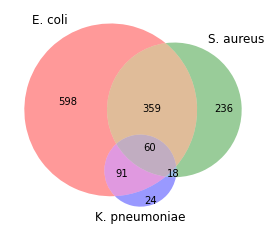

In [39]:
venn3(
    [
        set(ecoli_active.sequence.tolist()),
        set(saureus_active.sequence.tolist()),
        set(kpneumoniae_active.sequence.tolist()),
        
    ],
    ('E. coli', 'S. aureus', 'K. pneumoniae')
    
)
plt.show()

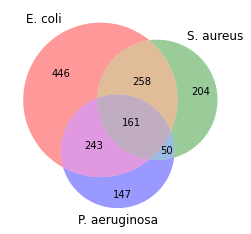

In [40]:
venn3(
    [
        set(ecoli_active.sequence.tolist()),
        set(saureus_active.sequence.tolist()),
        set(paeruginosa_active.sequence.tolist()),
        
    ],
    ('E. coli', 'S. aureus', 'P. aeruginosa')
    
)
plt.show()

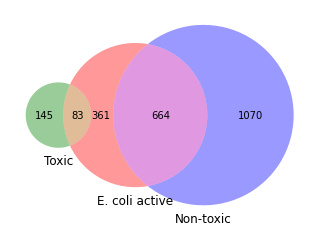

In [41]:
venn3(
    [
        set(ecoli_active.sequence.tolist()),
        set(toxic.sequence.tolist()),
        set(nontoxic.sequence.tolist()),
        
    ],
    ('E. coli active', 'Toxic', 'Non-toxic')
    
)
plt.show()